In [0]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras import layers
import glob
import os
import time
import tensorflow_datasets as tfds
import cv2

TensorFlow 2.x selected.


In [0]:
print(tf.__version__)

2.1.0


In [0]:
BUFFER_SIZE = 1020
BATCH_SIZE = 256

In [0]:
train_dataset = tfds.load("oxford_flowers102", split=tfds.Split.TRAIN, batch_size=-1)
numpy_ds = tfds.as_numpy(train_dataset)

In [0]:
train_images_np = numpy_ds["image"]
print(train_images_np.shape)

(1020, 993, 919, 3)


In [0]:
train_images = []
for i in train_images_np:
  train_images.append(cv2.resize(i, (128,128))/255)

train_images = np.array(train_images, dtype='float32')
print(train_images.shape)
train_images_np = []

(1020, 128, 128, 3)


In [0]:
def make_generator():
  model = tf.keras.Sequential()
  
  model.add(layers.Dense(32 * 32 * 256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((32,32,256)))

  #Conv2DTranspose blocks to create the images
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape == (None, 64, 64, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 128, 128, 3)

  return model

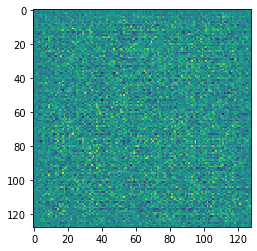

In [0]:
#Test generator while untrained
generator = make_generator()
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])
plt.show() 

In [0]:
def make_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[128,128,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
#test the untrained discriminator
discriminator = make_discriminator()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00025045]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = 'drive/My Drive/Flower_GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [0]:
EPOCHS = 10000
noise_dim = 100
num_example_to_generate = 16

#Will reuse this seed overtime
seed = tf.random.normal([num_example_to_generate, noise_dim])

In [0]:
@tf.function
def train_step(images):
  noise = tf.random.normal(([BATCH_SIZE, noise_dim]))
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #Generate the images from noise with training mode = True
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    if (epoch + 1) % 1000 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)


    
    print("Time for epoch {} was {} seconds".format(epoch+1, time.time() - start))

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(dataset)

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>


In [0]:
train(dataset, EPOCHS)

Time for epoch 1 was 5.892522811889648 seconds
Time for epoch 2 was 1.7959644794464111 seconds
Time for epoch 3 was 1.9989335536956787 seconds
Time for epoch 4 was 2.000302791595459 seconds
Time for epoch 5 was 1.9991188049316406 seconds
Time for epoch 6 was 1.9986562728881836 seconds
Time for epoch 7 was 1.9985833168029785 seconds
Time for epoch 8 was 1.999363899230957 seconds
Time for epoch 9 was 2.0001909732818604 seconds
Time for epoch 10 was 2.0002541542053223 seconds
Time for epoch 11 was 1.9999604225158691 seconds
Time for epoch 12 was 1.9982459545135498 seconds
Time for epoch 13 was 2.00042462348938 seconds
Time for epoch 14 was 2.0002083778381348 seconds
Time for epoch 15 was 2.0001277923583984 seconds
Time for epoch 16 was 2.0005085468292236 seconds
Time for epoch 17 was 1.999363899230957 seconds
Time for epoch 18 was 1.9987506866455078 seconds
Time for epoch 19 was 1.9991731643676758 seconds
Time for epoch 20 was 2.0014913082122803 seconds
Time for epoch 21 was 1.99955034255

In [0]:
#get a generated image
generated_test = generator(seed, training=False)
plt.imshow(generated_test[0, :, :, 0])
plt.show()

In [0]:
plt.imshow(train_images[0])
plt.show()

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))